In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [21]:
# util
import pandas as pd
import numpy as np
from matplotlib import dates
import matplotlib.pyplot as plt


def preprocess(N_rows, parse_dates, filename):
    total_rows = sum(1 for l in open(filename))
    variable_names = pd.read_csv(
        filename, header=0, delimiter=';', sep='', nrows=5)
    df = pd.read_csv(filename, header=0, delimiter=';', sep='', names=variable_names.columns,
                     parse_dates=parse_dates, index_col=0, nrows=N_rows, skiprows=total_rows - N_rows)
    df_no_na = df.replace('?', np.NaN)
    df_no_na.dropna(inplace=True)
    return df_no_na.astype(float)


def timeseries_plot(y, color, y_label):
    # y is Series with index of datetime
    days = dates.DayLocator()
    dfmt_minor = dates.DateFormatter('%m-%d')
    weekday = dates.WeekdayLocator(byweekday=(), interval=1)

    fig, ax = plt.subplots()
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_minor_formatter(dfmt_minor)

    ax.xaxis.set_major_locator(weekday)
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a'))

    ax.set_ylabel(y_label)
    ax.plot(y.index, y, color)
    fig.set_size_inches(12, 8)
    plt.tight_layout()
    plt.savefig(y_label + '.png', dpi=300)
    plt.show()

# average time series


def bucket_avg(ts, bucket):
    # ts is Sereis with index
    # bucket =["30T","60T","M".....]
    y = ts.resample(bucket).mean()
    return y


def config_plot():
    plt.style.use('seaborn-paper')
#    plt.rcParams.update({'axes.prop_cycle': cycler(color='jet')})
    plt.rcParams.update({'axes.titlesize': 20})
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams.update({'axes.labelsize': 22})
    plt.rcParams.update({'xtick.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'figure.figsize': (10, 6)})
    plt.rcParams.update({'legend.fontsize': 20})
    return 1


# static xgboost
# get one-hot encoder for features
def date_transform(df, encode_cols):
    # extract a few features from datetime
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['WeekofYear'] = df.index.weekofyear
    df['DayofWeek'] = df.index.weekday
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    # one hot encoder for categorical variables
    for col in encode_cols:
        df[col] = df[col].astype('category')
    df = pd.get_dummies(df, columns=encode_cols)
    return df


def get_unseen_data(unseen_start, steps, encode_cols, bucket_size):
    index = pd.date_range(unseen_start,
                          periods=steps, freq=bucket_size)
    df = pd.DataFrame(pd.Series(np.zeros(steps), index=index),
                      columns=['Global_active_power'])
    return df

# dynamic xgboost
# shift 2 steps for every lag


def data_add_timesteps(data, column, lag):
    column = data[column]
    step_columns = [column.shift(i) for i in range(2, lag + 1, 2)]
    df_steps = pd.concat(step_columns, axis=1)
    # current Global_active_power is at first columns
    df = pd.concat([data, df_steps], axis=1)
    return df

In [80]:
parse_dates = [['Date', 'Time']]
filename = "./Data/energyex/household_power_consumption.txt"
encode_cols = ['Month', 'DayofWeek', 'Hour']
bucket_size="60T"

In [81]:
# (1)  data is not datetime ordered. It is random
N_rows = 60000
df = preprocess(N_rows, parse_dates, filename)

G_power=df["Global_active_power"]
#G_power_sort=G_power.sort_values('index')

In [85]:
G_power.index

DatetimeIndex(['2010-10-16 05:04:00', '2010-10-16 05:05:00',
               '2010-10-16 05:06:00', '2010-10-16 05:07:00',
               '2010-10-16 05:08:00', '2010-10-16 05:09:00',
               '2010-10-16 05:10:00', '2010-10-16 05:11:00',
               '2010-10-16 05:12:00', '2010-10-16 05:13:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='Date_Time', length=59998, freq=None)

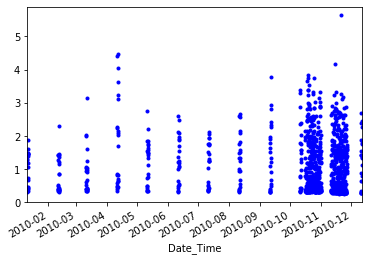

In [49]:
df = pd.DataFrame(bucket_avg(G_power,bucket_size))
df.dropna(inplace=True)
df.Global_active_power.plot(style='b.')
plt.show()

In [51]:
# focusing on last 19000 data rows
N_rows=19000
df = preprocess(N_rows, parse_dates, filename)
G_power=df['Global_active_power']
print(G_power.shape)
df_G = pd.DataFrame(bucket_avg(G_power,bucket_size))
df_G.dropna(inplace=True)

(18999,)


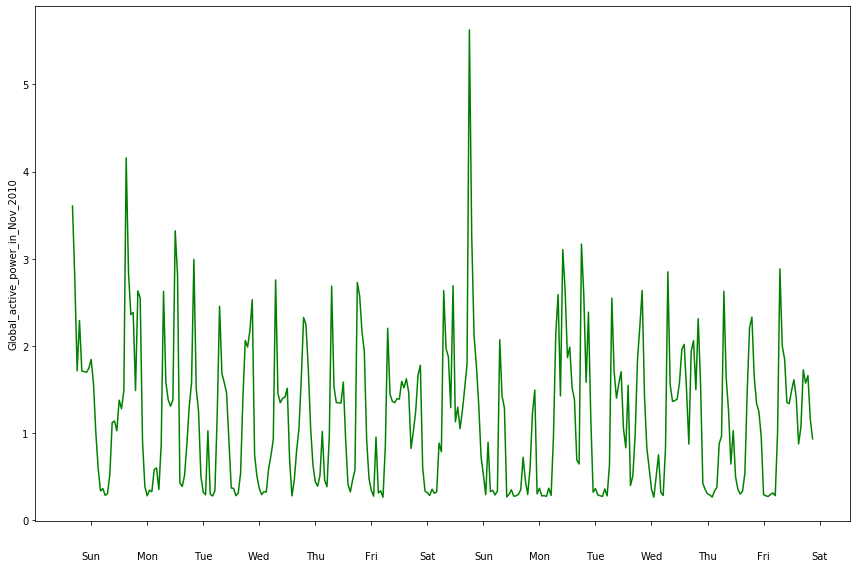

In [52]:
ts_label = 'Global_active_power_in_Nov_2010'
timeseries_plot(df_G.Global_active_power,'g',ts_label)

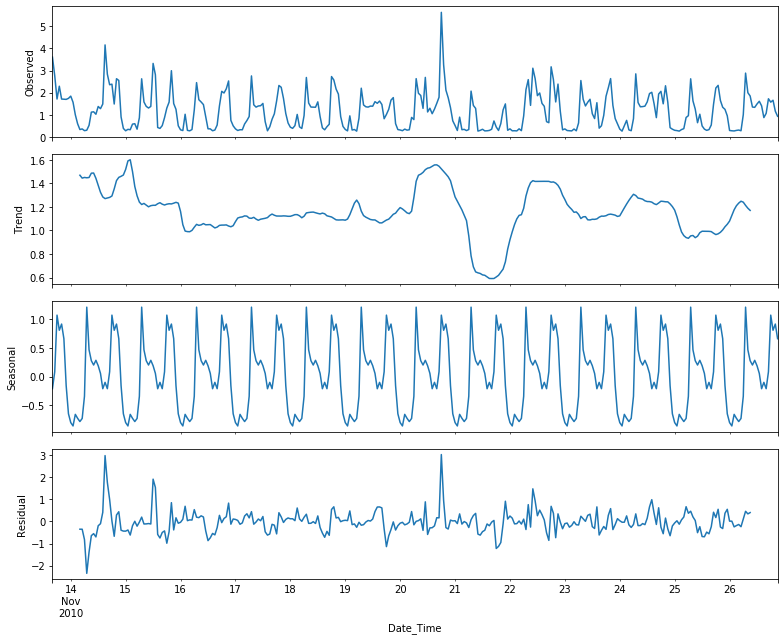

In [53]:
# component plot
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(df_G.Global_active_power, model='additive')
fig = decomposition.plot()
plt.tight_layout()
plt.savefig( 'ts_decomposition_plot.png', dpi=300)
plt.show()

                     Global_active_power Time of Day        Date
Date_Time                                                       
2010-11-13 16:00:00             3.605278    16:00:00  2010-11-13
2010-11-13 17:00:00             2.761567    17:00:00  2010-11-13
2010-11-13 18:00:00             1.715300    18:00:00  2010-11-13
2010-11-13 19:00:00             2.292333    19:00:00  2010-11-13
2010-11-13 20:00:00             1.713167    20:00:00  2010-11-13


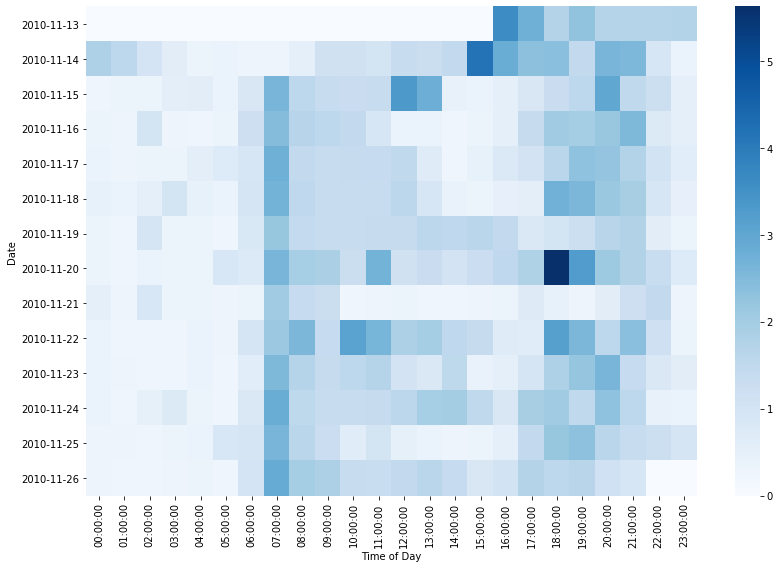

In [54]:
# heatmap
df_G['Time of Day'] = df_G.index.time
df_G['Date'] = df_G.index.date
print(df_G.head())
dfG_pivot = df_G.pivot_table(index="Date", columns="Time of Day",values='Global_active_power',fill_value=0)
dfG_pivot.head()
plt.figure(figsize=(12, 8))
sn.heatmap(dfG_pivot,cmap='Blues')
plt.tight_layout()
plt.show()

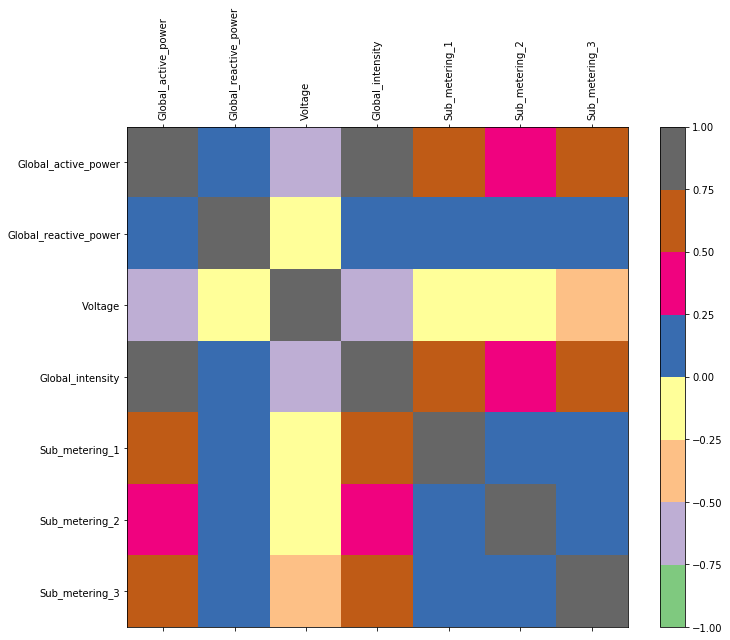

In [55]:
# correlation plot
names = df.columns
correlations = df.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap='Accent')
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation = 90)
ax.set_yticklabels(names)
#plt.figure(figsize=(8,8))
plt.tight_layout()
plt.show()

In [57]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm


class Arima_Class:
    def __init__(self, arima_para, seasonal_para):
        # Define the p, d and q parameters in Arima(p,d,q)(P,D,Q) models
        p = arima_para['p']
        d = arima_para['d']
        q = arima_para['q']
        # Generate all different combinations of p, q and q triplets
        self.pdq = list(itertools.product(p, d, q))
        # Generate all different combinations of seasonal p, q and q triplets
        self.seasonal_pdq = [(x[0], x[1], x[2], seasonal_para)
                             for x in list(itertools.product(p, d, q))]

    def fit(self, ts):
        warnings.filterwarnings("ignore")
        results_list = []
        for param in self.pdq:
            for param_seasonal in self.seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(ts,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()

                    print('ARIMA{}x{}seasonal - AIC:{}'.format(param,
                                                               param_seasonal, results.aic))
                    results_list.append([param, param_seasonal, results.aic])
                except:
                    continue
        results_list = np.array(results_list)
        lowest_AIC = np.argmin(results_list[:, 2])
        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print('ARIMA{}x{}seasonal with lowest_AIC:{}'.format(
            results_list[lowest_AIC, 0], results_list[lowest_AIC, 1], results_list[lowest_AIC, 2]))
        print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

        mod = sm.tsa.statespace.SARIMAX(ts,
                                        order=results_list[lowest_AIC, 0],
                                        seasonal_order=results_list[lowest_AIC, 1],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        self.final_result = mod.fit()
        print('Final model summary:')
        print(self.final_result.summary().tables[1])
        print('Final model diagnostics:')
        self.final_result.plot_diagnostics(figsize=(15, 12))
        plt.tight_layout()
        plt.savefig('model_diagnostics.png', dpi=300)
        plt.show()

    def pred(self, ts, plot_start, pred_start, dynamic, ts_label):

        pred_dynamic = self.final_result.get_prediction(
            start=pd.to_datetime(pred_start), dynamic=dynamic, full_results=True)
        pred_dynamic_ci = pred_dynamic.conf_int()
        ax = ts[plot_start:].plot(label='observed', figsize=(15, 10))

        if dynamic == False:
            pred_dynamic.predicted_mean.plot(
                label='One-step ahead Forecast', ax=ax)
        else:
            pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

        ax.fill_between(pred_dynamic_ci.index,
                        pred_dynamic_ci.iloc[:, 0],
                        pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
        ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(plot_start), ts.index[-1],
                         alpha=.1, zorder=-1)
        ax.set_xlabel('Time')
        ax.set_ylabel(ts_label)
        plt.legend()
        plt.tight_layout()
        if dynamic == False:
            plt.savefig(ts_label + '_one_step_pred.png', dpi=300)
        else:
            plt.savefig(ts_label + '_dynamic_pred.png', dpi=300)
        plt.show()

    def forcast(self, ts, n_steps, ts_label):
        # Get forecast n_steps ahead in future
        pred_uc = self.final_result.get_forecast(steps=n_steps)

        # Get confidence intervals of forecasts
        pred_ci = pred_uc.conf_int()
        ax = ts.plot(label='observed', figsize=(15, 10))
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast in Future')
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Time')
        ax.set_ylabel(ts_label)
        plt.tight_layout()
        plt.savefig(ts_label + '_forcast.png', dpi=300)
        plt.legend()
        plt.show()

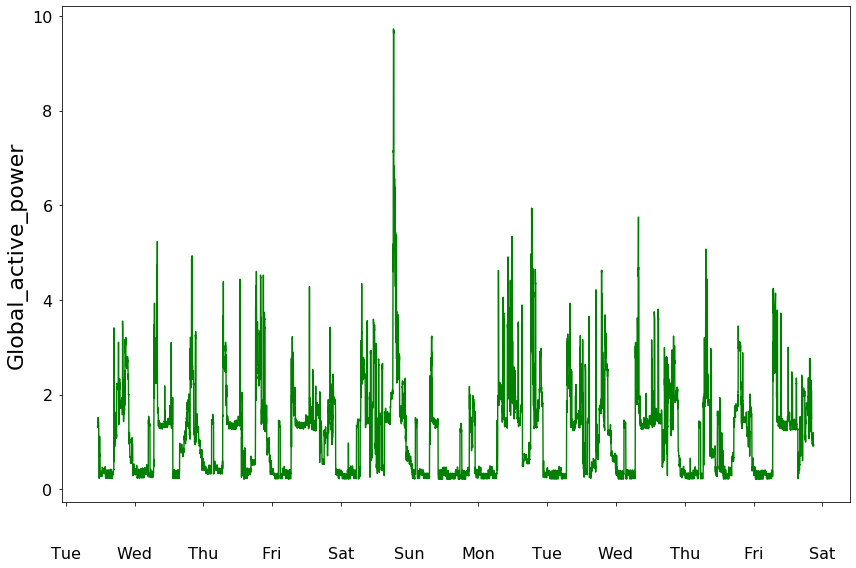

In [60]:
import pandas as pd

config_plot()


# we focus on the last 10 days data in Nov 2010
N_rows = 15000
parse_dates = [['Date', 'Time']]
filename = "./Data/energyex/household_power_consumption.txt"

df = preprocess(N_rows, parse_dates, filename)

G_power = pd.to_numeric(df["Global_active_power"])
# time series plot of one-minute sampling rate data
timeseries_plot(G_power, 'g', 'Global_active_power')


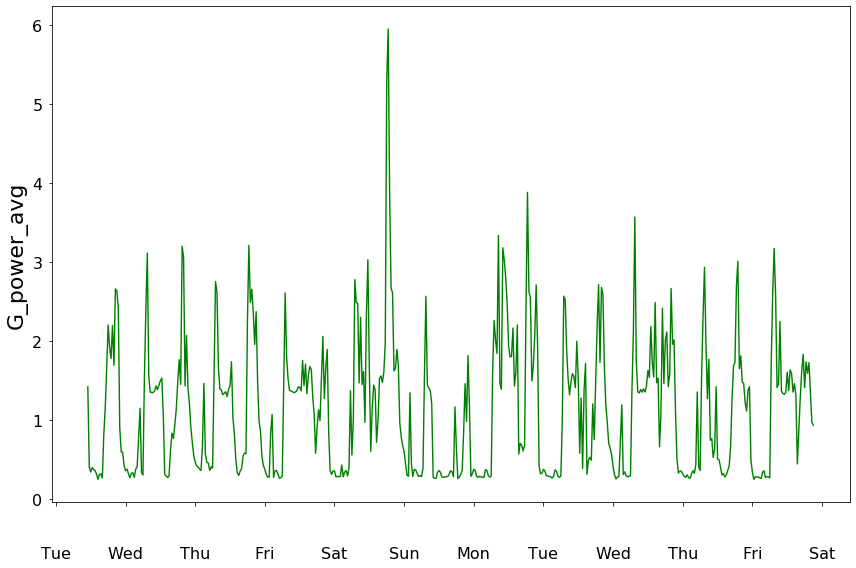

In [61]:

# we take a 30 minutes bucket average of our time series data to reduce noise.
bucket_size = "30T"
G_power_avg = bucket_avg(G_power, bucket_size)
# plot of 30 minutes average.
ts_label = 'G_power_avg'
timeseries_plot(G_power_avg, 'g', ts_label)


ARIMA(0, 0, 0)x(0, 0, 0, 48)seasonal - AIC:1771.0049185060252
ARIMA(0, 0, 0)x(0, 0, 1, 48)seasonal - AIC:1461.3363324435577
ARIMA(0, 0, 0)x(0, 1, 0, 48)seasonal - AIC:1231.1132522685461
ARIMA(0, 0, 0)x(0, 1, 1, 48)seasonal - AIC:826.0255510185643
ARIMA(0, 0, 0)x(1, 0, 0, 48)seasonal - AIC:1184.506509851788
ARIMA(0, 0, 0)x(1, 0, 1, 48)seasonal - AIC:918.3082554917044
ARIMA(0, 0, 0)x(1, 1, 0, 48)seasonal - AIC:876.4462294705828
ARIMA(0, 0, 0)x(1, 1, 1, 48)seasonal - AIC:788.2434489202154
ARIMA(0, 0, 1)x(0, 0, 0, 48)seasonal - AIC:1304.1490094893397
ARIMA(0, 0, 1)x(0, 0, 1, 48)seasonal - AIC:1090.9292595032707
ARIMA(0, 0, 1)x(0, 1, 0, 48)seasonal - AIC:1013.4115545401667
ARIMA(0, 0, 1)x(0, 1, 1, 48)seasonal - AIC:656.5525010603244
ARIMA(0, 0, 1)x(1, 0, 0, 48)seasonal - AIC:943.7197043673627
ARIMA(0, 0, 1)x(1, 0, 1, 48)seasonal - AIC:734.8749914605296
ARIMA(0, 0, 1)x(1, 1, 0, 48)seasonal - AIC:737.6475776501707
ARIMA(0, 0, 1)x(1, 1, 1, 48)seasonal - AIC:649.5107542788298
ARIMA(0, 1, 0)x(0,

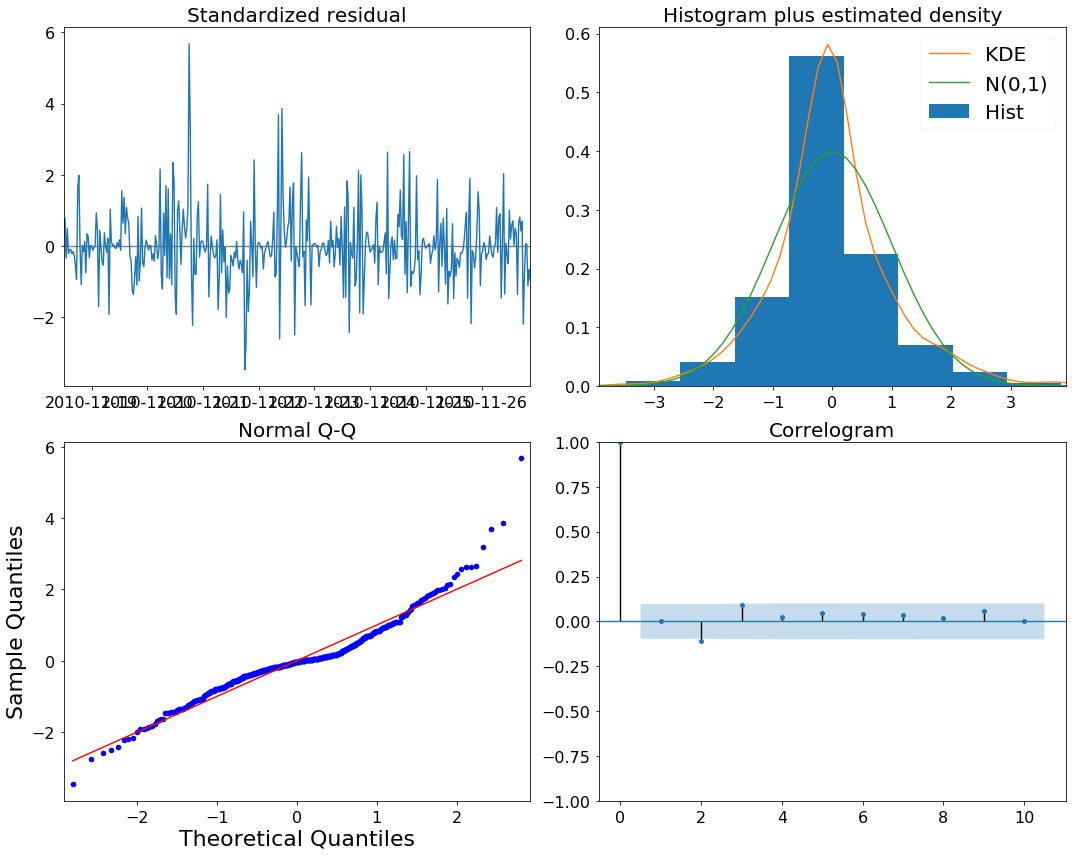

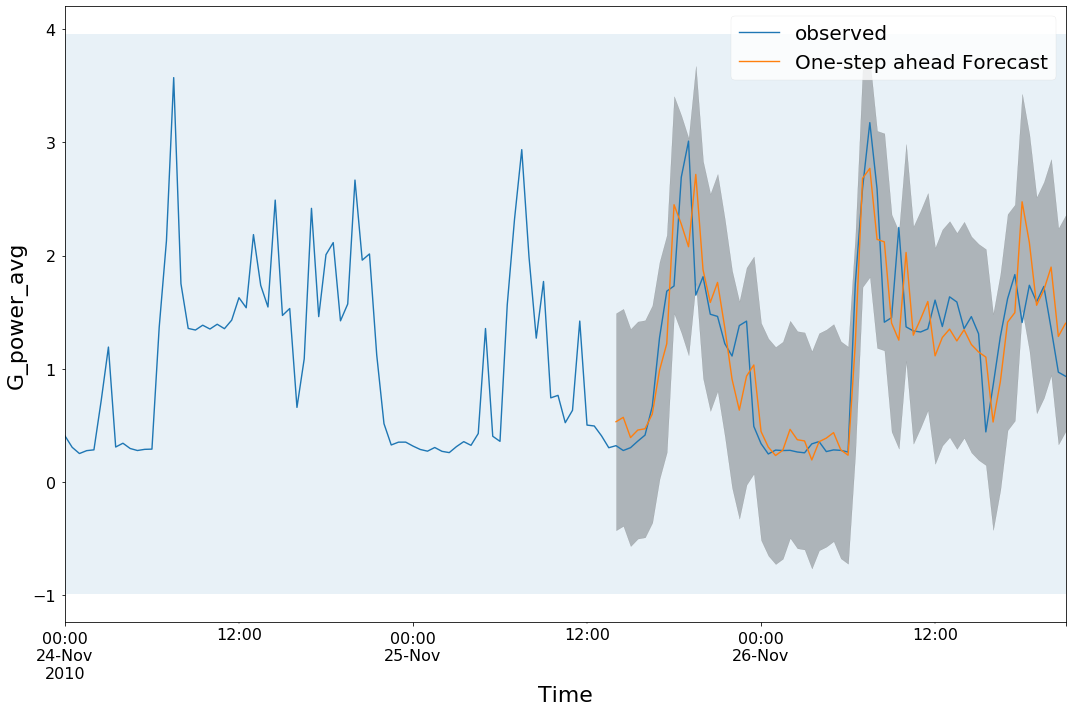

In [62]:
# "Grid search" of seasonal ARIMA model.
# the seasonal periodicy 24 hours, i.e. S=24*60/30 = 48 samples
arima_para = {}
arima_para['p'] = range(2)
arima_para['d'] = range(2)
arima_para['q'] = range(2)
# the seasonal periodicy is  24 hours
seasonal_para = round(24 * 60 / (float(bucket_size[:-1])))
arima = Arima_Class(arima_para, seasonal_para)

arima.fit(G_power_avg)



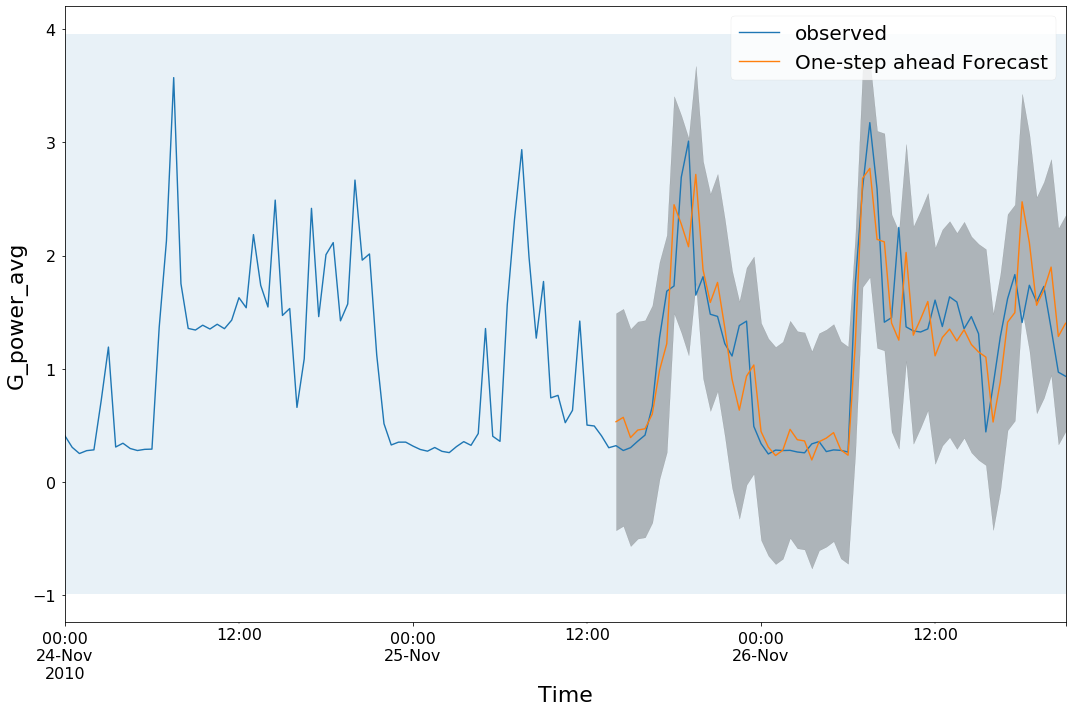

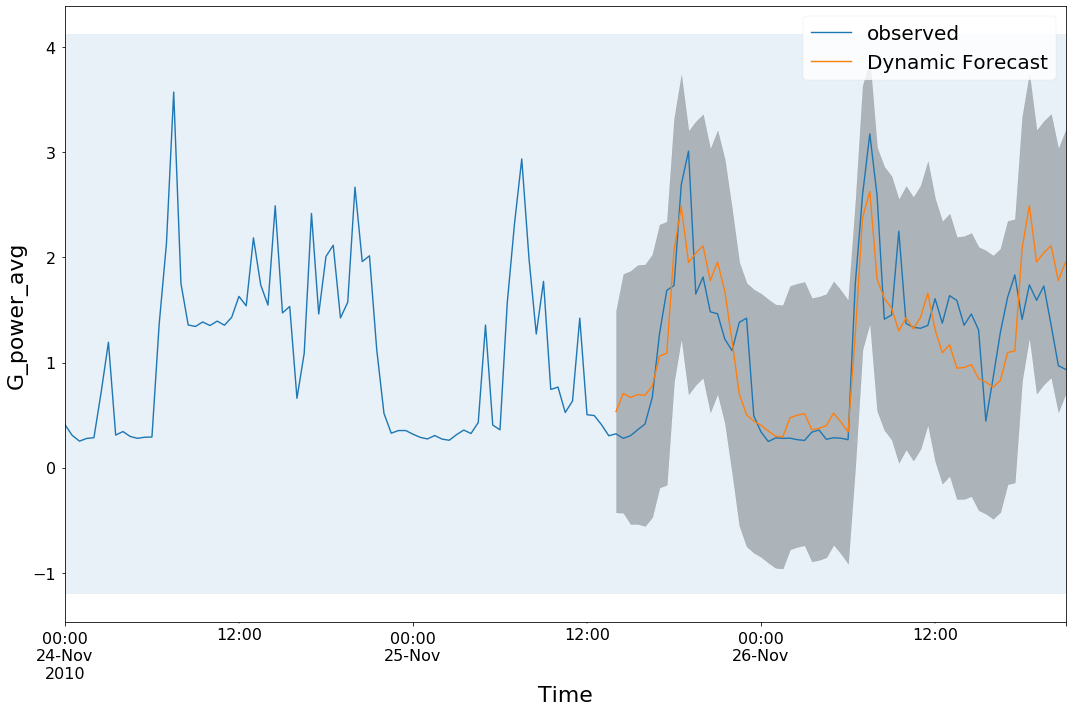

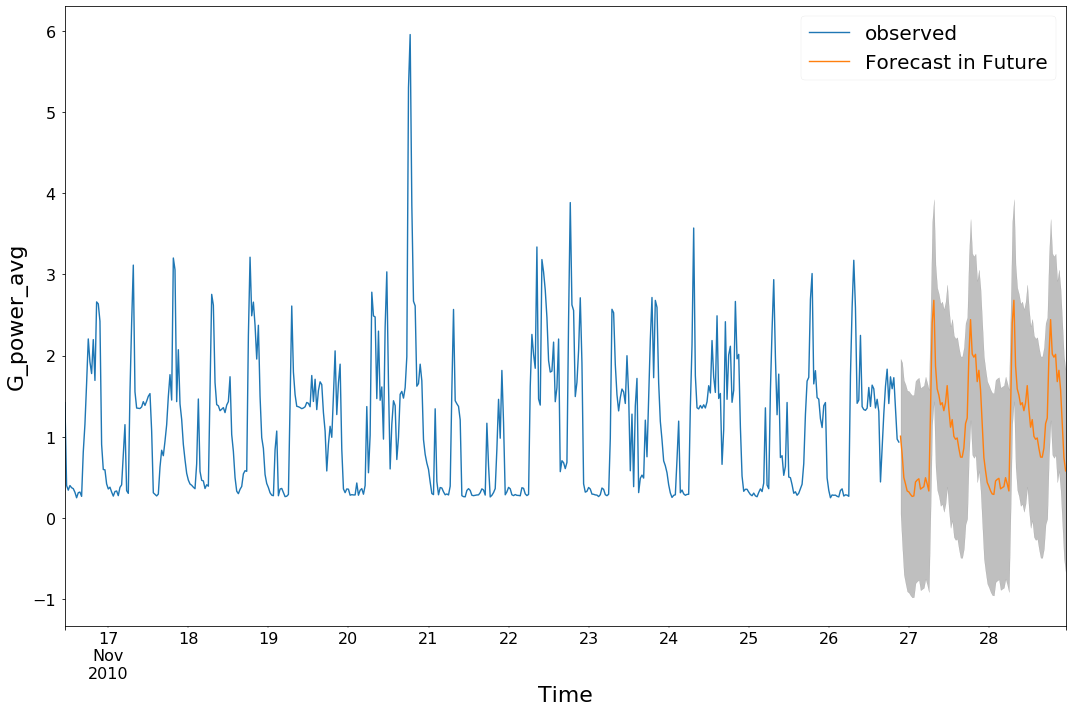

In [64]:
# Prediction on observed data starting on pred_start
# observed and prediction starting dates in plots
plot_start = '2010-11-24 00:00:00'
pred_start = '2010-11-25 14:00:00'

# One-step ahead forecasts
dynamic = False
arima.pred(G_power_avg, plot_start, pred_start, dynamic, ts_label)

# Dynamic forecasts
dynamic = True
arima.pred(G_power_avg, plot_start, pred_start, dynamic, ts_label)

# Forecasts to unseen future data
n_steps = 100  # next 100 * 30 min = 50 hours
arima.forcast(G_power_avg, n_steps, ts_label)

# XGBoost

In [65]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import operator
import matplotlib.pyplot as plt

# get data for train, test, and forecast(unseen)


def xgb_data_split(df, bucket_size, unseen_start_date, steps, test_start_date, encode_cols):
    # generate unseen data
    unseen = get_unseen_data(unseen_start_date, steps,
                             encode_cols, bucket_size)
    df = pd.concat([df, unseen], axis=0)
    df = date_transform(df, encode_cols)

    # data for forecast ,skip the connecting point
    df_unseen = df[unseen_start_date:].iloc[:, 1:]
    test_start = '2010-11-26 00:00:00'
    # skip the connecting point
    df_test = df[test_start_date: unseen_start_date].iloc[:-1, :]
    df_train = df[:test_start_date]
    return df_unseen, df_test, df_train


def feature_importance_plot(importance_sorted, title):
    df = pd.DataFrame(importance_sorted, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    plt.figure()
    # df.plot()
    df.plot(kind='barh', x='feature', y='fscore',
            legend=False, figsize=(12, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.tight_layout()
    plt.savefig(title + '.png', dpi=300)
    plt.show()


def xgb_importance(df, test_ratio, xgb_params, ntree, early_stop, plot_title):
    df = pd.DataFrame(df)
    # split the data into train/test set
    Y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                        test_size=test_ratio,
                                                        random_state=42)

    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'validate')]

    xgb_model = xgb.train(xgb_params, dtrain, ntree, evals=watchlist,
                          early_stopping_rounds=early_stop, verbose_eval=True)

    importance = xgb_model.get_fscore()
    importance_sorted = sorted(importance.items(), key=operator.itemgetter(1))
    feature_importance_plot(importance_sorted, plot_title)


def xgb_forecasts_plot(plot_start, Y, Y_test, Y_hat, forecasts, title):
    Y = pd.concat([Y, Y_test])
    ax = Y[plot_start:].plot(label='observed', figsize=(15, 10))
    #Y_test.plot(label='test_observed', ax=ax)
    Y_hat.plot(label="predicted", ax=ax)
    forecasts.plot(label="forecast", ax=ax)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(Y_test.index[0]), Y_test.index[-1],
                     alpha=.1, zorder=-1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Global Active Power')
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + '.png', dpi=300)
    plt.show()

-----Xgboost Using All Numeric Features----- 
---inital model feature importance---
[14:15:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.05513	validate-rmse:1.09795
Multiple eval metrics have been passed: 'validate-rmse' will be used for early stopping.

Will train until validate-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.950948	validate-rmse:0.98946
[2]	train-rmse:0.857312	validate-rmse:0.892395
[3]	train-rmse:0.773054	validate-rmse:0.804751
[4]	train-rmse:0.707394	validate-rmse:0.737193
[5]	train-rmse:0.637904	validate-rmse:0.664898
[6]	train-rmse:0.580449	validate-rmse:0.605555
[7]	train-rmse:0.523485	validate-rmse:0.545857
[8]	train-rmse:0.472503	validate-rmse:0.492919
[9]	train-rmse:0.426469	validate-rmse:0.445248
[10]	train-rmse:0.385211	validate-rmse:0.402113
[11]	train-rmse:0.347784	validate-rmse:0.363462
[12]	train-rmse:0.320895	validate-rmse

[162]	train-rmse:0.0069	validate-rmse:0.02732
[163]	train-rmse:0.006847	validate-rmse:0.02731
[164]	train-rmse:0.006814	validate-rmse:0.027308
[165]	train-rmse:0.006749	validate-rmse:0.027303
[166]	train-rmse:0.006713	validate-rmse:0.027296
[167]	train-rmse:0.006681	validate-rmse:0.02729
[168]	train-rmse:0.006621	validate-rmse:0.027284
[169]	train-rmse:0.006599	validate-rmse:0.027282
[170]	train-rmse:0.006573	validate-rmse:0.027284
[171]	train-rmse:0.006526	validate-rmse:0.027277
[172]	train-rmse:0.006506	validate-rmse:0.02728
[173]	train-rmse:0.006431	validate-rmse:0.027267
[174]	train-rmse:0.006411	validate-rmse:0.027265
[175]	train-rmse:0.006358	validate-rmse:0.027249
[176]	train-rmse:0.006325	validate-rmse:0.027237
[177]	train-rmse:0.006319	validate-rmse:0.02723
[178]	train-rmse:0.006279	validate-rmse:0.027221
[179]	train-rmse:0.006246	validate-rmse:0.027212
[180]	train-rmse:0.006232	validate-rmse:0.02721
[181]	train-rmse:0.006195	validate-rmse:0.027205
[182]	train-rmse:0.006153	va

<Figure size 720x432 with 0 Axes>

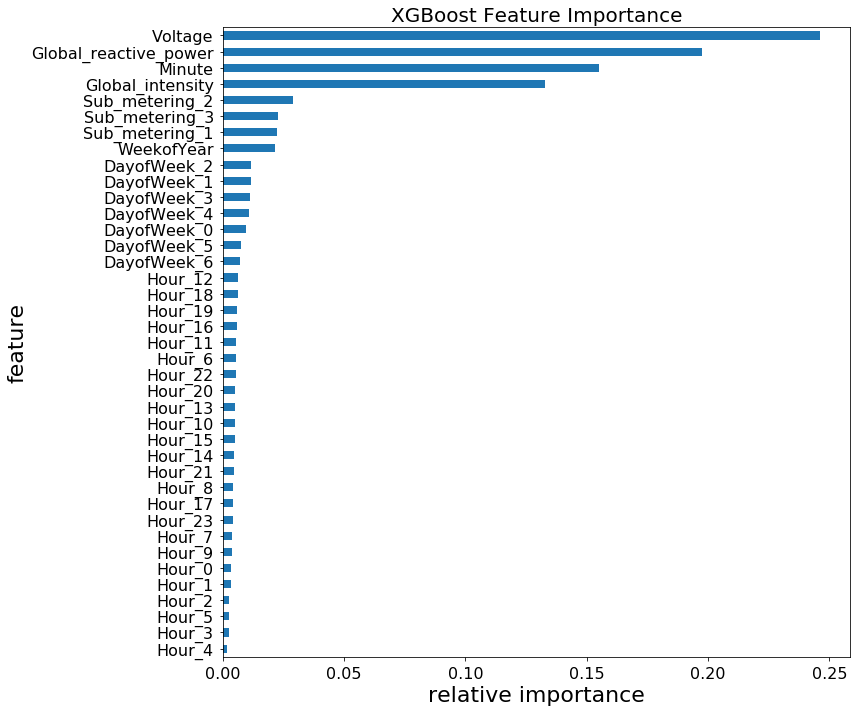

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor  # wrapper
import scipy.stats as st

config_plot()


##############################################################################
# we only focus on the last 18000 points for datetime information
# Run xgboost on all features
# get data
N_rows = 18000
parse_dates = [['Date', 'Time']]

encode_cols = ['Month', 'DayofWeek', 'Hour']

df = preprocess(N_rows, parse_dates, filename)
# keep all features
df = date_transform(df, encode_cols)

# base parameters
xgb_params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',  # regression task
    'subsample': 0.80,  # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85,  # 85% of features used
    'eta': 0.1,
    'max_depth': 10,
    'seed': 42}  # for reproducible results

val_ratio = 0.3
ntree = 300
early_stop = 50

print('-----Xgboost Using All Numeric Features-----',
      '\n---inital model feature importance---')
fig_allFeatures = xgb_importance(
    df, val_ratio, xgb_params, ntree, early_stop, 'All Features')
plt.show()


In [70]:

#############################################################################
# xgboost using only datetime information
bucket_size = "5T"
df = preprocess(N_rows, parse_dates, filename)
G_power = df["Global_active_power"]

df = pd.DataFrame(bucket_avg(G_power, bucket_size))
df.dropna(inplace=True)
df.iloc[-1, :].index  # last time step  #2010-11-26 21:00:00

test_start_date = '2010-11-25 20:00:00'
unseen_start_date = '2010-11-26 21:10:00'
steps = 200

# get splited data
df_unseen, df_test, df = xgb_data_split(
    df, bucket_size, unseen_start_date, steps, test_start_date, encode_cols)
print('\n-----Xgboost on only datetime information---------\n')

dim = {'train and validation data ': df.shape,
       'test data ': df_test.shape,
       'forecasting data ': df_unseen.shape}
print(pd.DataFrame(list(dim.items()), columns=['Data', 'dimension']))



-----Xgboost on only datetime information---------

                         Data   dimension
0  train and validation data   (3301, 36)
1                  test data    (301, 36)
2           forecasting data    (200, 35)


In [72]:

# train model
Y = df.iloc[:, 0]
X = df.iloc[:, 1:]
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=val_ratio,
                                                  random_state=42)

X_test = xgb.DMatrix(df_test.iloc[:, 1:])
Y_test = df_test.iloc[:, 0]
X_unseen = xgb.DMatrix(df_unseen)

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
watchlist = [(dtrain, 'train'), (dval, 'validate')]

# Grid Search
params_sk = {
    'objective': 'reg:squarederror',
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'seed': 42}

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [73]:

params_grid = {"n_estimators": st.randint(100, 500),
               #                "colsample_bytree": st.beta(10, 1),
               #                "subsample": st.beta(10, 1),
               #                "gamma": st.uniform(0, 10),
               #                'reg_alpha': st.expon(0, 50),
               #                "min_child_weight": st.expon(0, 50),
               #               "learning_rate": st.uniform(0.06, 0.12),
               'max_depth': st.randint(6, 30)
               }
search_sk = RandomizedSearchCV(
    skrg, params_grid, cv=5, random_state=1, n_iter=20)  # 5 fold cross validation
search_sk.fit(X, Y)


C:\Users\choyou\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.85, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',...
                                          seed=42, silent=None, subsample=0.8,
                                          verbosity=1),
                   iid='warn', n_iter=20, n_jobs=None,
                   param_distributions={'m

best parameters: {'max_depth': 7, 'n_estimators': 171}
best score: 0.08157291964172006
[0]	train-rmse:1.00081	validate-rmse:1.01367
Multiple eval metrics have been passed: 'validate-rmse' will be used for early stopping.

Will train until validate-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.870578	validate-rmse:0.886225
[2]	train-rmse:0.791493	validate-rmse:0.814069
[3]	train-rmse:0.722346	validate-rmse:0.758484
[4]	train-rmse:0.688467	validate-rmse:0.728328
[5]	train-rmse:0.636315	validate-rmse:0.684022
[6]	train-rmse:0.607951	validate-rmse:0.658616
[7]	train-rmse:0.58685	validate-rmse:0.640504
[8]	train-rmse:0.563608	validate-rmse:0.620455
[9]	train-rmse:0.547166	validate-rmse:0.610046
-----Xgboost Using Datetime Features Only------ 
---Grid Search model feature importance---


<Figure size 720x432 with 0 Axes>

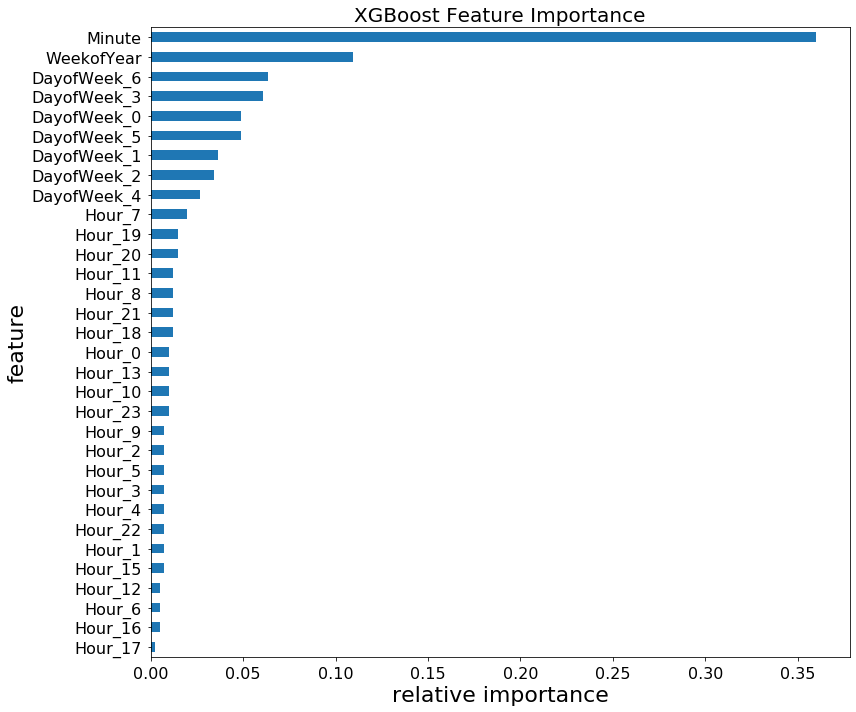

In [74]:

# best parameters
print("best parameters:", search_sk.best_params_); print(
    "best score:", search_sk.best_score_)
# with new parameters
params_new = {**params_sk, **search_sk.best_params_}

model_final = xgb.train(params_new, dtrain, evals=watchlist,
                        early_stopping_rounds=early_stop, verbose_eval=True)

print('-----Xgboost Using Datetime Features Only------',
      '\n---Grid Search model feature importance---')
importance = model_final.get_fscore()
importance_sorted = sorted(importance.items(), key=operator.itemgetter(1))
fig1 = feature_importance_plot(importance_sorted, 'feature importance')
plt.show()


-----Xgboost Using Datetime Features Only------ 
---Forecasting from Grid Search---


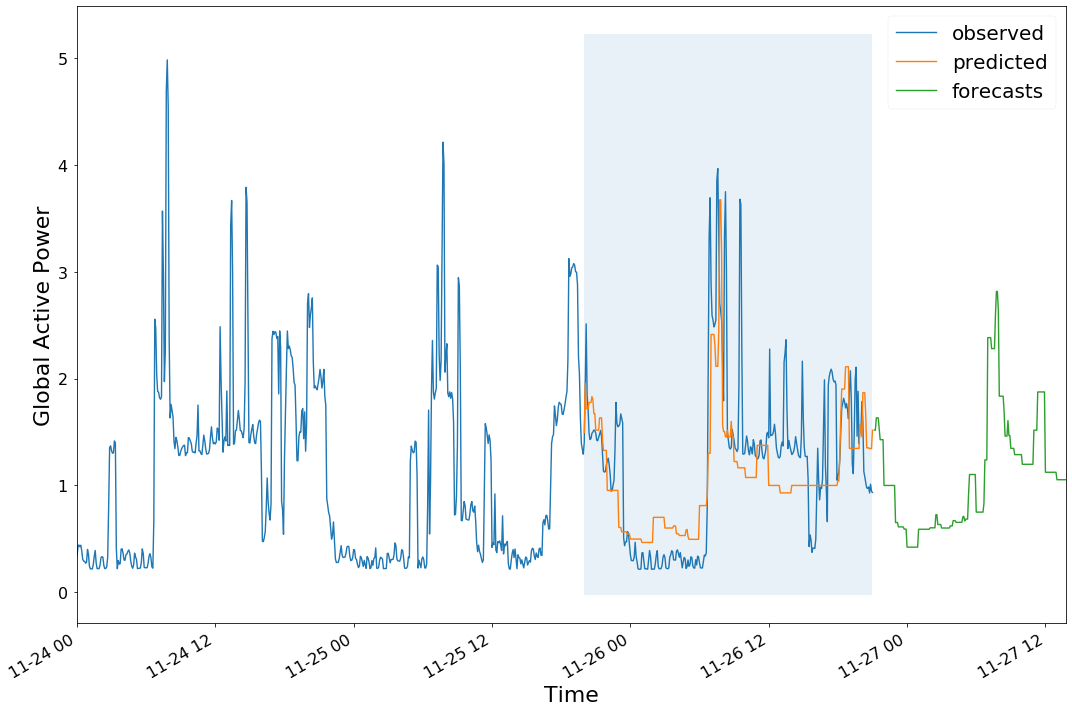

In [76]:

#############################################################################
# Forcasting
# prediction to testing data
Y_hat = model_final.predict(X_test)
Y_hat = pd.DataFrame(Y_hat, index=Y_test.index, columns=["predicted"])

# predictions to unseen future data
unseen_y = model_final.predict(X_unseen)
forecasts = pd.DataFrame(
    unseen_y, index=df_unseen.index, columns=["forecasts"])

# plot forcast results using grid search final model
plot_start = '2010-11-24 00:00:00'
print('-----Xgboost Using Datetime Features Only------',
      '\n---Forecasting from Grid Search---')
forecasts_plot2 = xgb_forecasts_plot(
    plot_start, Y, Y_test, Y_hat, forecasts, 'Grid Search')


[14:30:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-----Xgboost Using Datetime Features Only------ 
---Forecasting from initial---


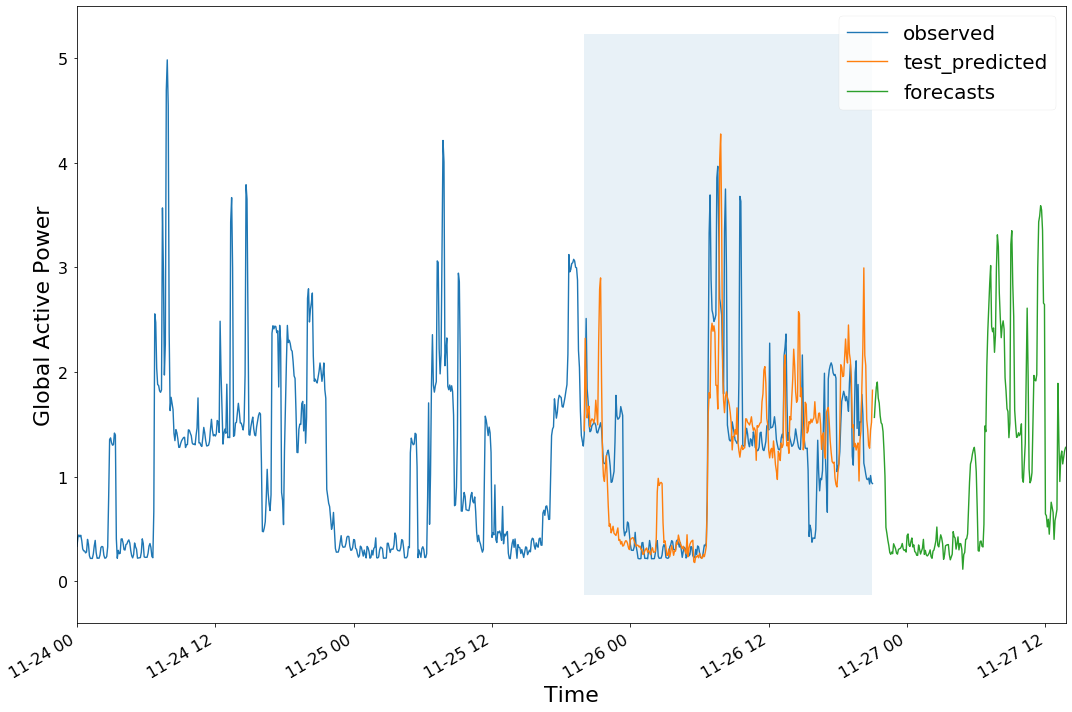

In [77]:
# forcasts results using itinial model
xgb_model = xgb.train(xgb_params, dtrain, ntree, evals=watchlist,
                      early_stopping_rounds=early_stop, verbose_eval=False)
Y_hat = xgb_model.predict(X_test)
Y_hat = pd.DataFrame(Y_hat, index=Y_test.index, columns=["test_predicted"])
unseen_y = xgb_model.predict(X_unseen)
forecasts = pd.DataFrame(
    unseen_y, index=df_unseen.index, columns=["forecasts"])
plot_start = '2010-11-24 00:00:00'
print('-----Xgboost Using Datetime Features Only------',
      '\n---Forecasting from initial---')
forecasts_plot1 = xgb_forecasts_plot(
    plot_start, Y, Y_test, Y_hat, forecasts, 'Initial Model')